In [1]:
from tqdm import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
nlp=spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 

In [2]:
career_persona = pd.read_json("../data/career_persona.json")

In [3]:
career_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  332 non-null    int64 
 1   trait     332 non-null    object
 2   answer    332 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.9+ KB


In [4]:
def normalize_subject(subject):
    # Process the subject using spaCy
    doc = nlp(subject)
    
    # Extract the normalized form of the subject
    normalized_subject = " ".join([token.lemma_ for token in doc])
    
    return normalized_subject

In [5]:
career_persona["answer_processed"] = career_persona["answer"].apply(lambda t : normalize_subject(t))

In [6]:
career_persona

,question,trait,answer,answer_processed
0,1,creative,They would describe me as someone with an imag...,they would describe I as someone with an imagi...
1,1,creative,Friends and family often see me as a creative ...,friend and family often see I as a creative th...
2,1,creative,They might describe me as the family's creativ...,they might describe I as the family 's creativ...
3,1,creative,My loved ones often label me as a creative ind...,my loved one often label I as a creative indiv...
4,1,creative,I'm often seen as the creative spark in our fa...,I be often see as the creative spark in our fa...
...,...,...,...,...
327,6,empathetic,I focus on optimizing the app's communication ...,I focus on optimize the app 's communication f...
328,6,empathetic,I place great importance on effective marketin...,I place great importance on effective marketin...
329,6,empathetic,"App security is a top priority, and I take mea...","app security be a top priority , and I take me..."
330,6,empathetic,I'd place great importance on monetization str...,I would place great importance on monetization...


In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [8]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern])  # Note the change here

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return span.text

In [9]:
def get_kg_trait(data, trait,cols):
    if trait == None:
        data = data
    else:
        data = data[data.trait==trait]
    relations = [get_relation(i) for i in tqdm(data[cols])]
    
    entity_pairs = []

    for i in tqdm(data[cols]):
      entity_pairs.append(get_entities(i))
        
        
    # extract subject
    source = [i[0] for i in entity_pairs]
    
    # extract object
    target = [i[1] for i in entity_pairs]
    
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    
    
    return kg_df

def viz_kg(data):
    # create a directed-graph from a dataframe
    G=nx.from_pandas_edgelist(data, "source", "target", 
                              edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(15,15))
    
    pos = nx.spring_layout(G)
    
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    # Extract edge labels from the dataframe
    edge_labels = {(row["source"], row["target"]): row["edge"] for _, row in data.iterrows()}
    
    # Draw edge labels on the graph
    nx.draw_networkx_edge_labels(G, 
                                 pos,
                                 edge_labels=edge_labels)
    
    
    

In [10]:
all_data = get_kg_trait(career_persona, trait = None, cols = "answer_processed")

100%|██████████| 332/332 [00:03<00:00, 105.29it/s]


In [11]:
top_edge = all_data.edge.value_counts().index[:20]
top_source = all_data.source.value_counts().index[:20]

In [12]:
creative = get_kg_trait(career_persona,"creative", cols = "answer_processed")
creative

100%|██████████| 41/41 [00:00<00:00, 98.83it/s] 


,source,target,edge
0,they,innovative idea,describe
1,creative who,fresh situation,see
2,they,new myself,describe
3,I,everything,label
4,I,inventive solution,find inventive
5,they,creative reality,describe
6,I,unique perspective,explore
7,that,artistic painting,choose
8,top I,imaginative storytelling,allow
9,I,visual storytelling,enroll in


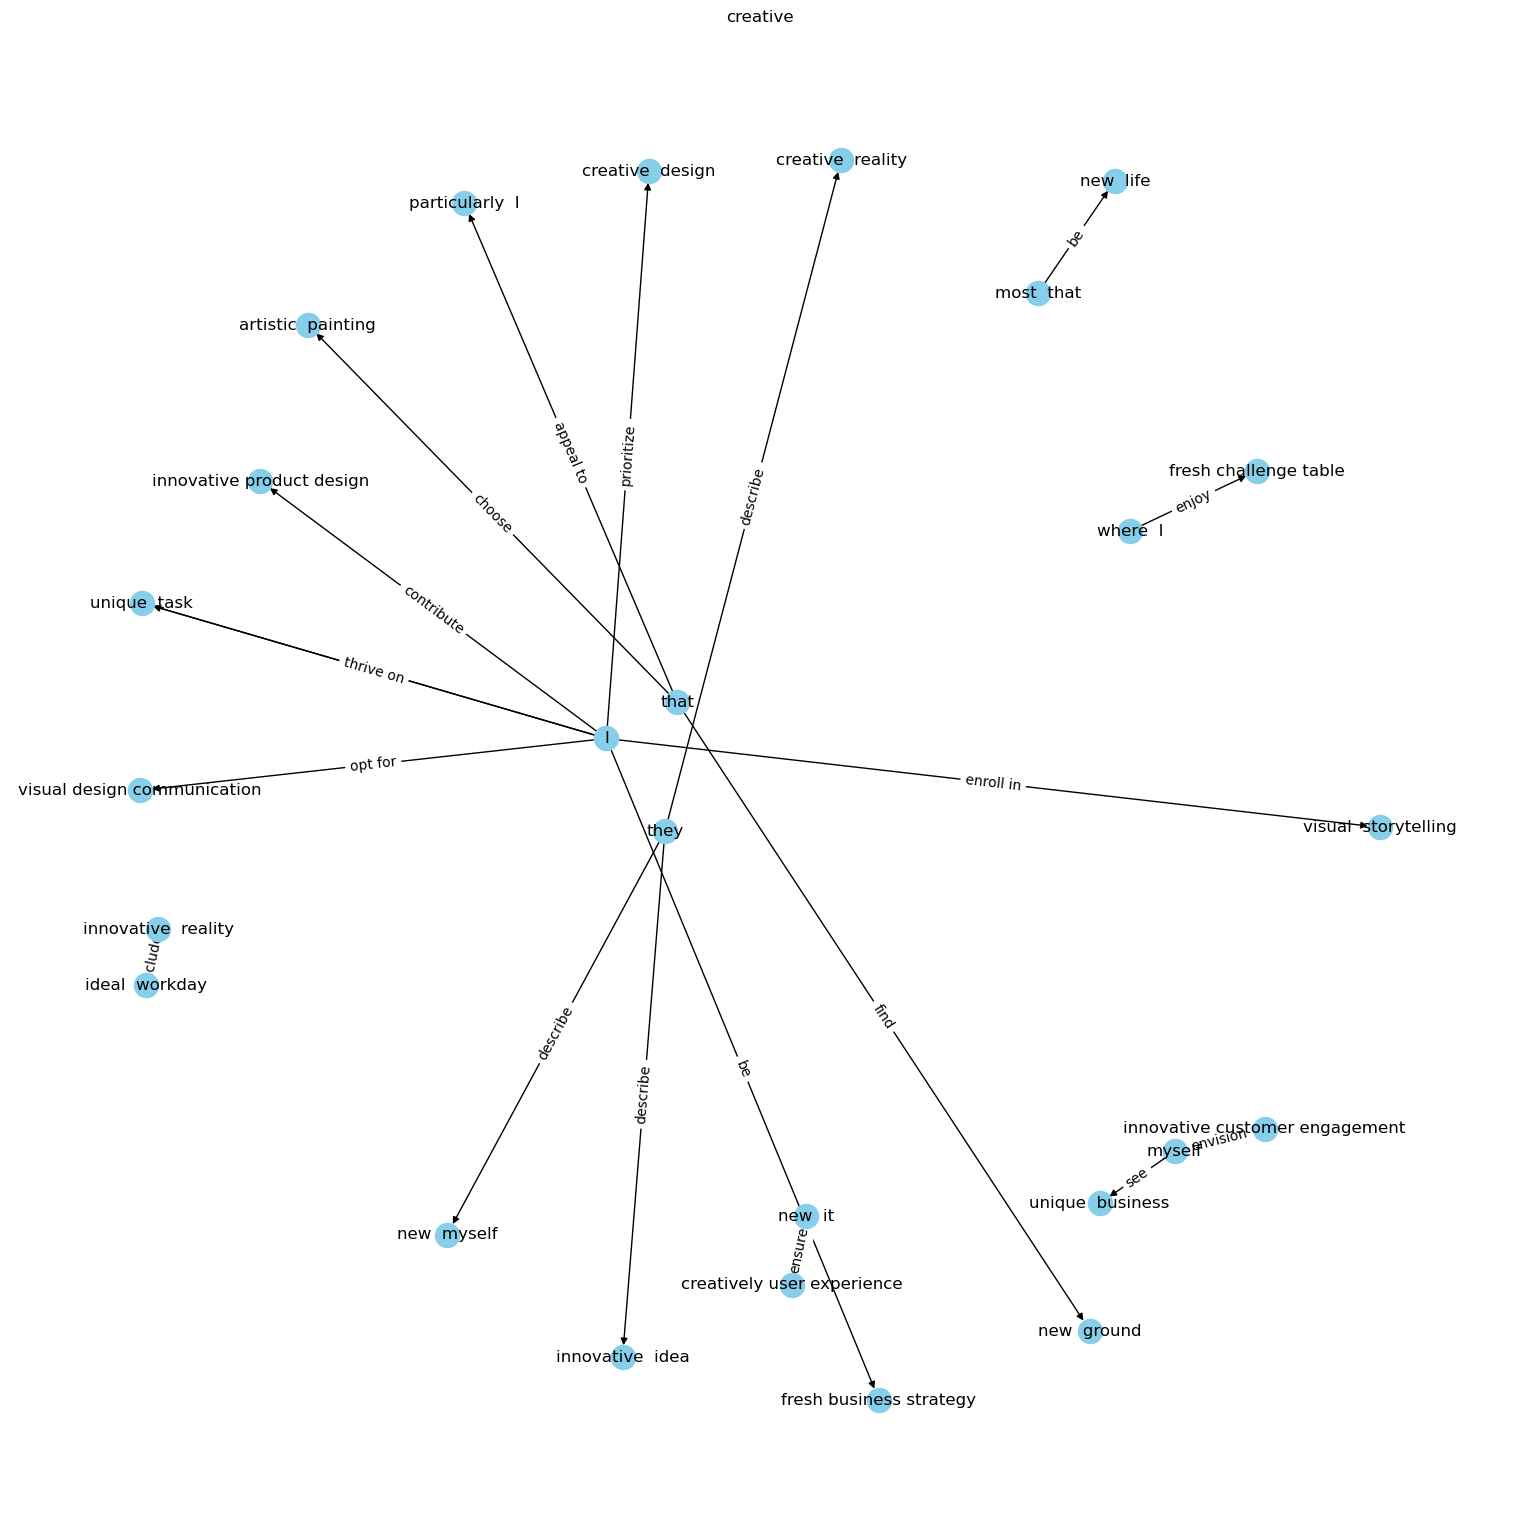

In [13]:
viz_kg(creative[creative.edge.isin(top_edge) & creative.source.isin(top_source)])
plt.title("creative")
plt.show()

In [14]:
logical = get_kg_trait(career_persona,"logical-thinker", cols = "answer_processed")
logical

100%|██████████| 35/35 [00:00<00:00, 105.03it/s]


,source,target,edge
0,troubleshoot I,go help,make
1,often who,complex problem,label as
2,often who,consistently root they,regard as
3,who,chaotic facilitate problem resolution,People
4,I,complex problem solve issue,choose
5,top decision it,informed analyze choice,be
6,that,different angle,enroll in
7,conflict it,beneficial solution,see
8,statistical datum it,valuable data drive problem,opt for
9,problem project solving,project obstacle,envision


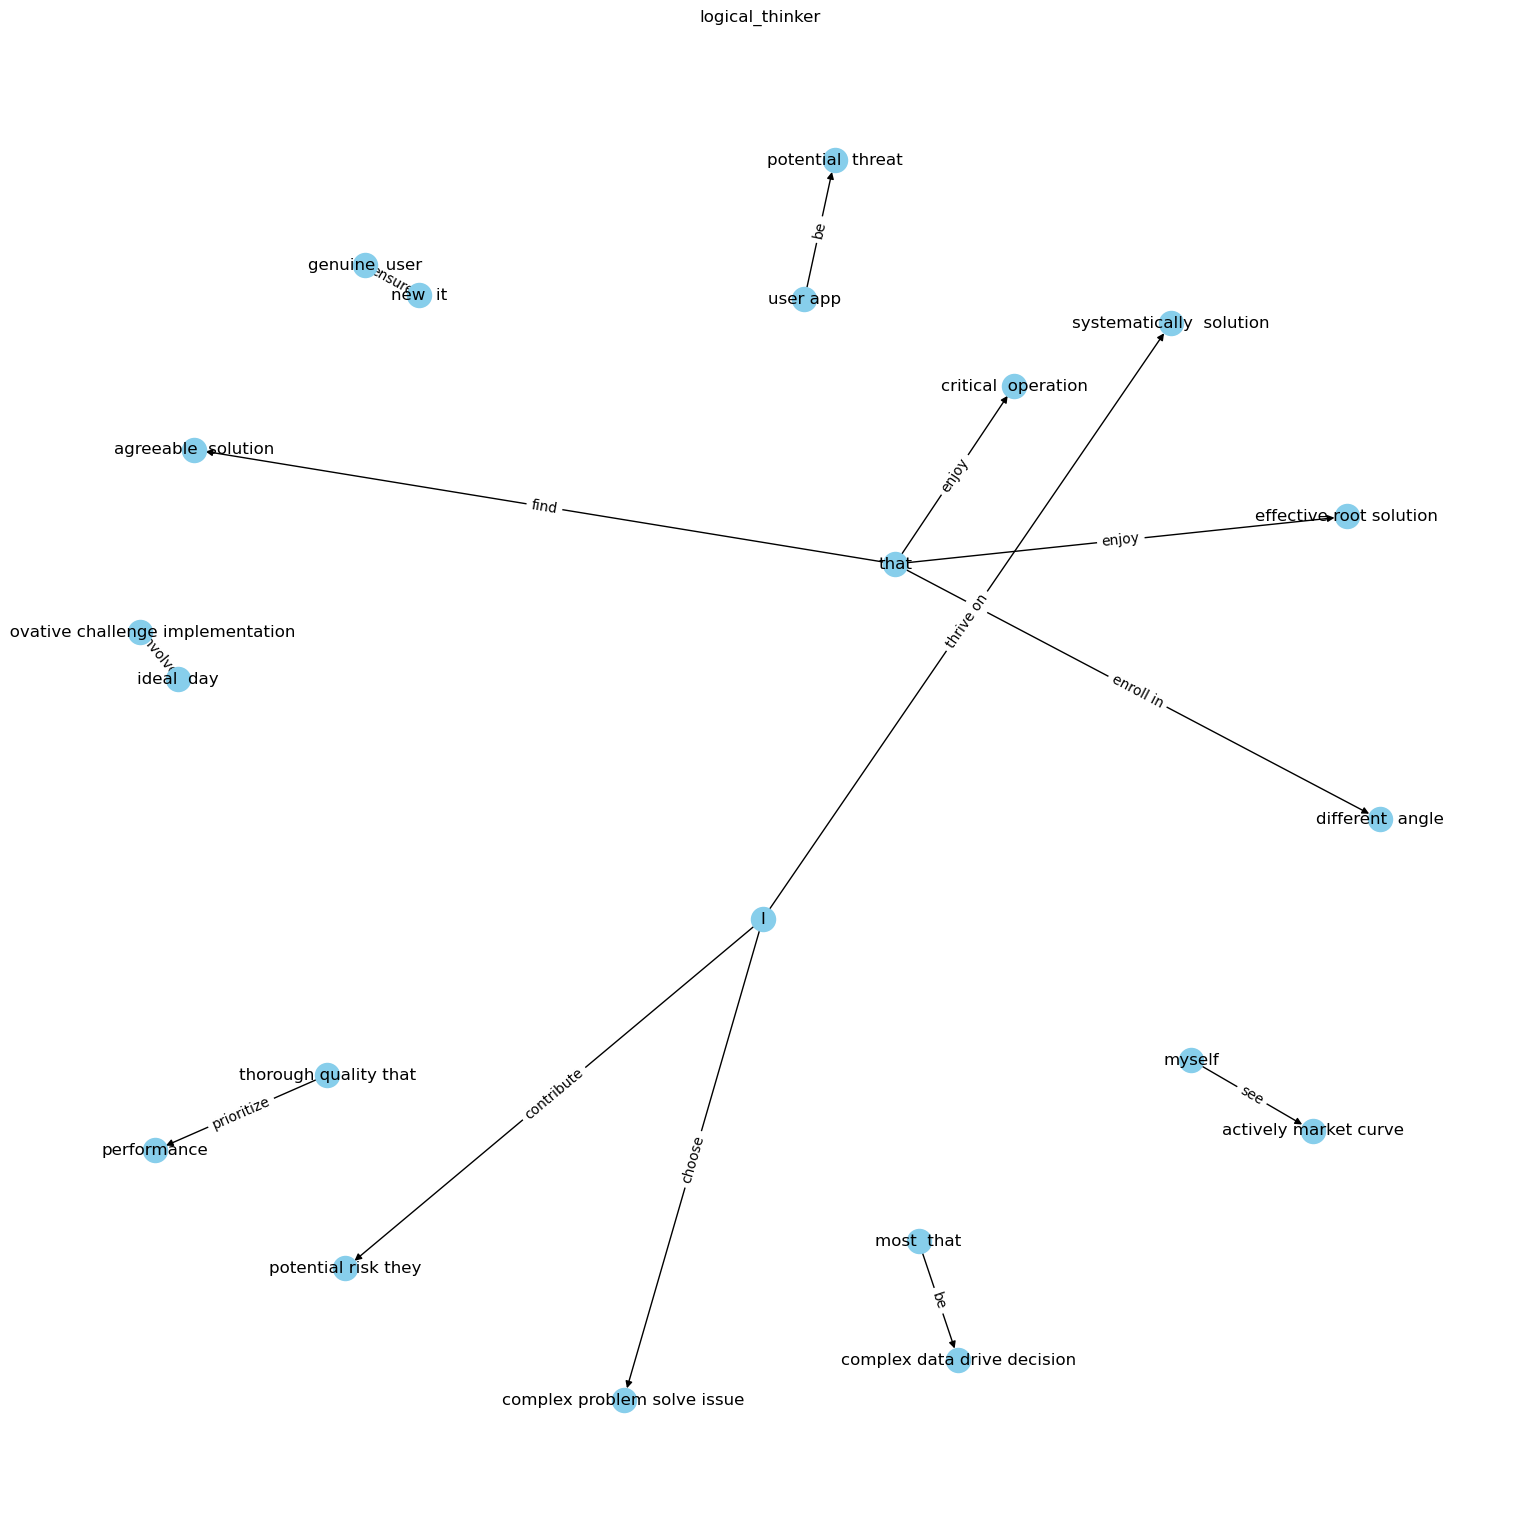

In [15]:
viz_kg(logical[logical.edge.isin(top_edge) & logical.source.isin(top_source)])
plt.title("logical_thinker")
plt.show()

In [16]:
analytical = get_kg_trait(career_persona,"analytical", cols = "answer_processed")
analytical

100%|██████████| 50/50 [00:00<00:00, 100.28it/s]


,source,target,edge
0,likely who,complex issue,describe
1,critical who,choice,recognize as
2,who,consistently datum pattern,see
3,who,consistently datum pattern,see
4,likely who,available inform conclusion information,describe
5,friend,comprehensive analyze issue,appreciate
6,likely who,available inform conclusion information,describe
7,I,decision data ability,choose
8,top it,found evaluate judgment,be
9,experimental research it,thorough analysis,enroll in


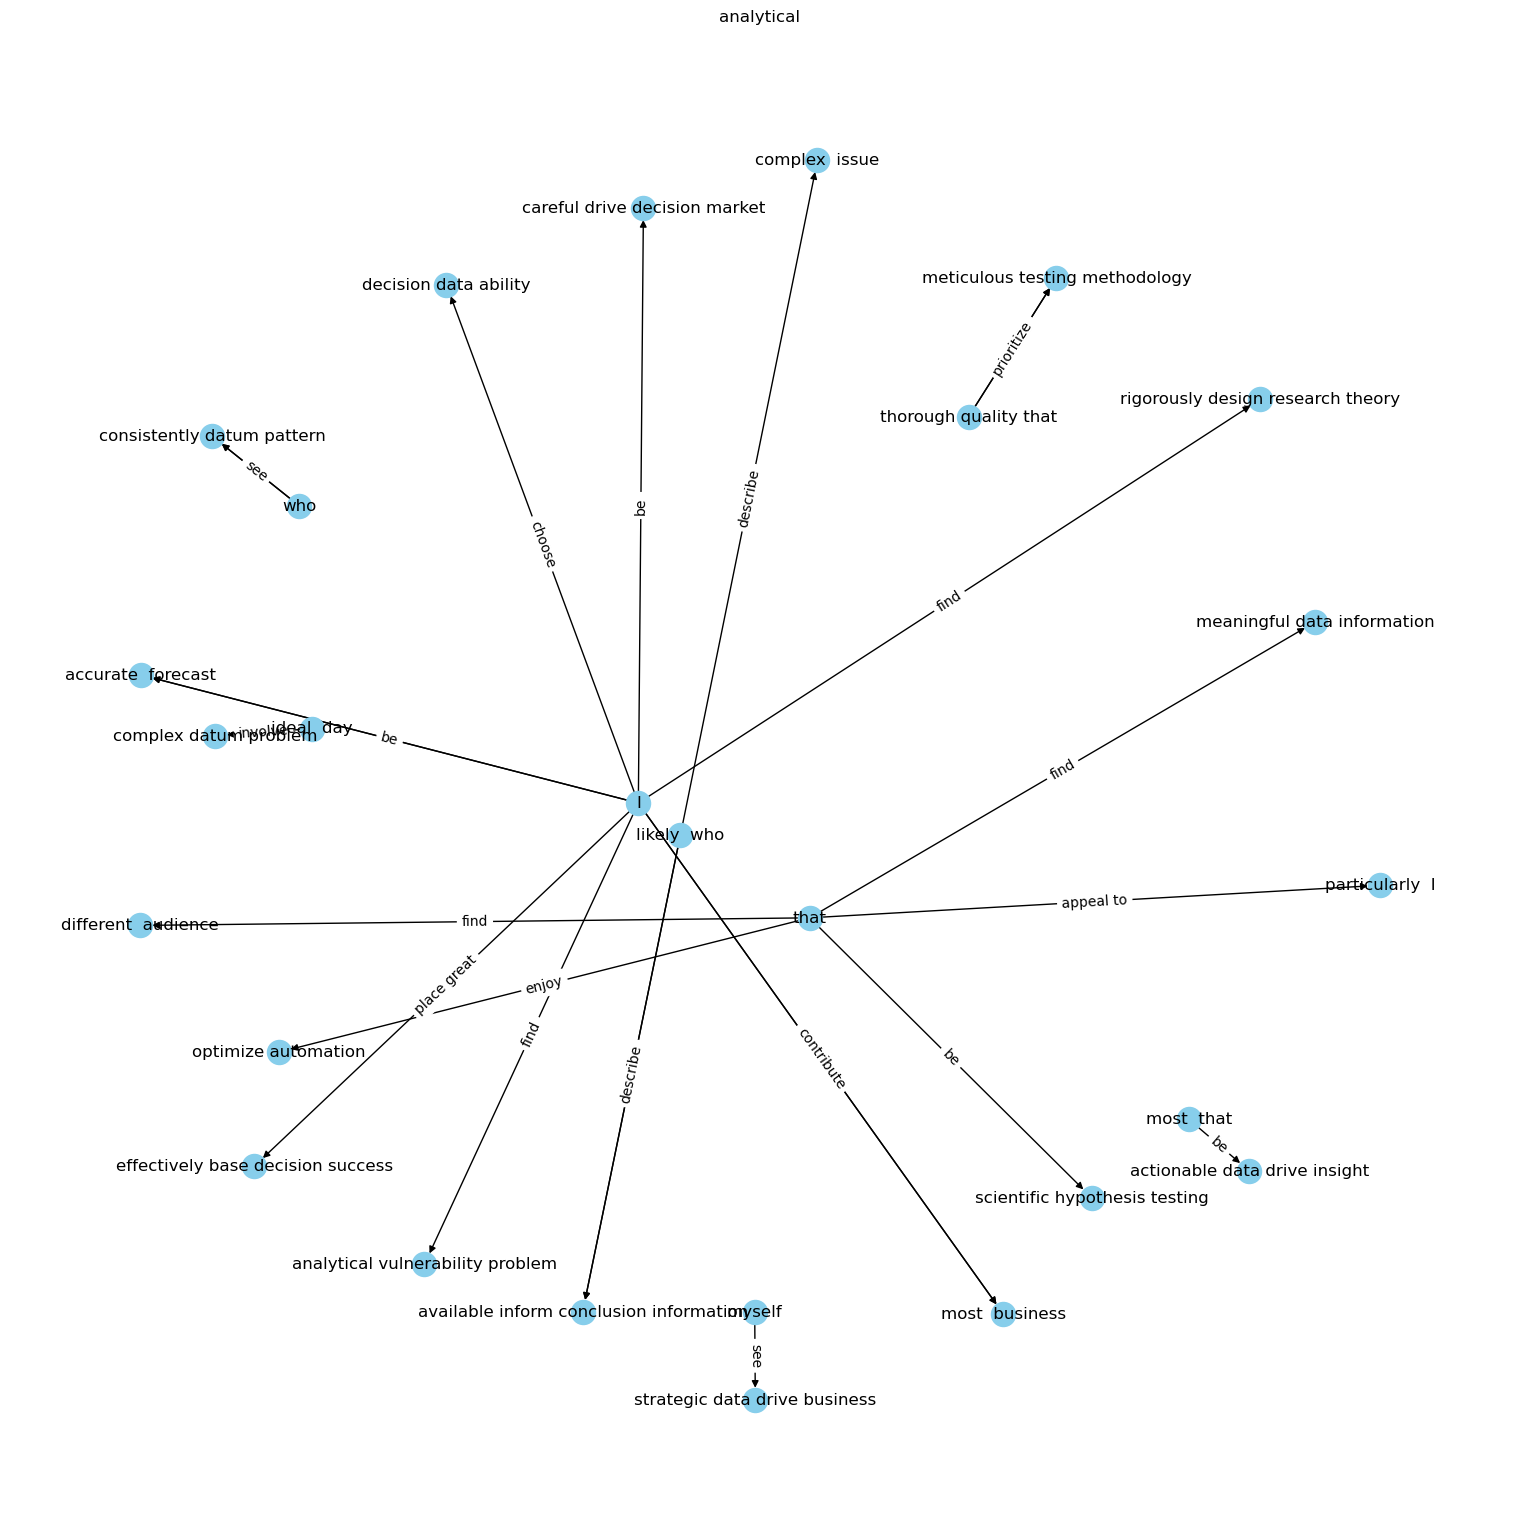

In [17]:
viz_kg(analytical[analytical.edge.isin(top_edge) & analytical.source.isin(top_source)])
plt.title("analytical")
plt.show()

In [18]:
data_driven = get_kg_trait(career_persona, "data-driven", cols="answer_processed")
data_driven

100%|██████████| 49/49 [00:00<00:00, 106.79it/s]


,source,target,edge
0,likely data drive who,informed decision,describe
1,likely who,datum progress,describe
2,often who,actionable data drive discussion,recognize as
3,who,meaningful datum,see
4,when detail it,collection,describe
5,who,research data argument,say
6,likely who,data drive circumstance,describe
7,I,well situation,People
8,who,complex discussion,see as
9,advanced datum it,data drive evidence base decision,choose


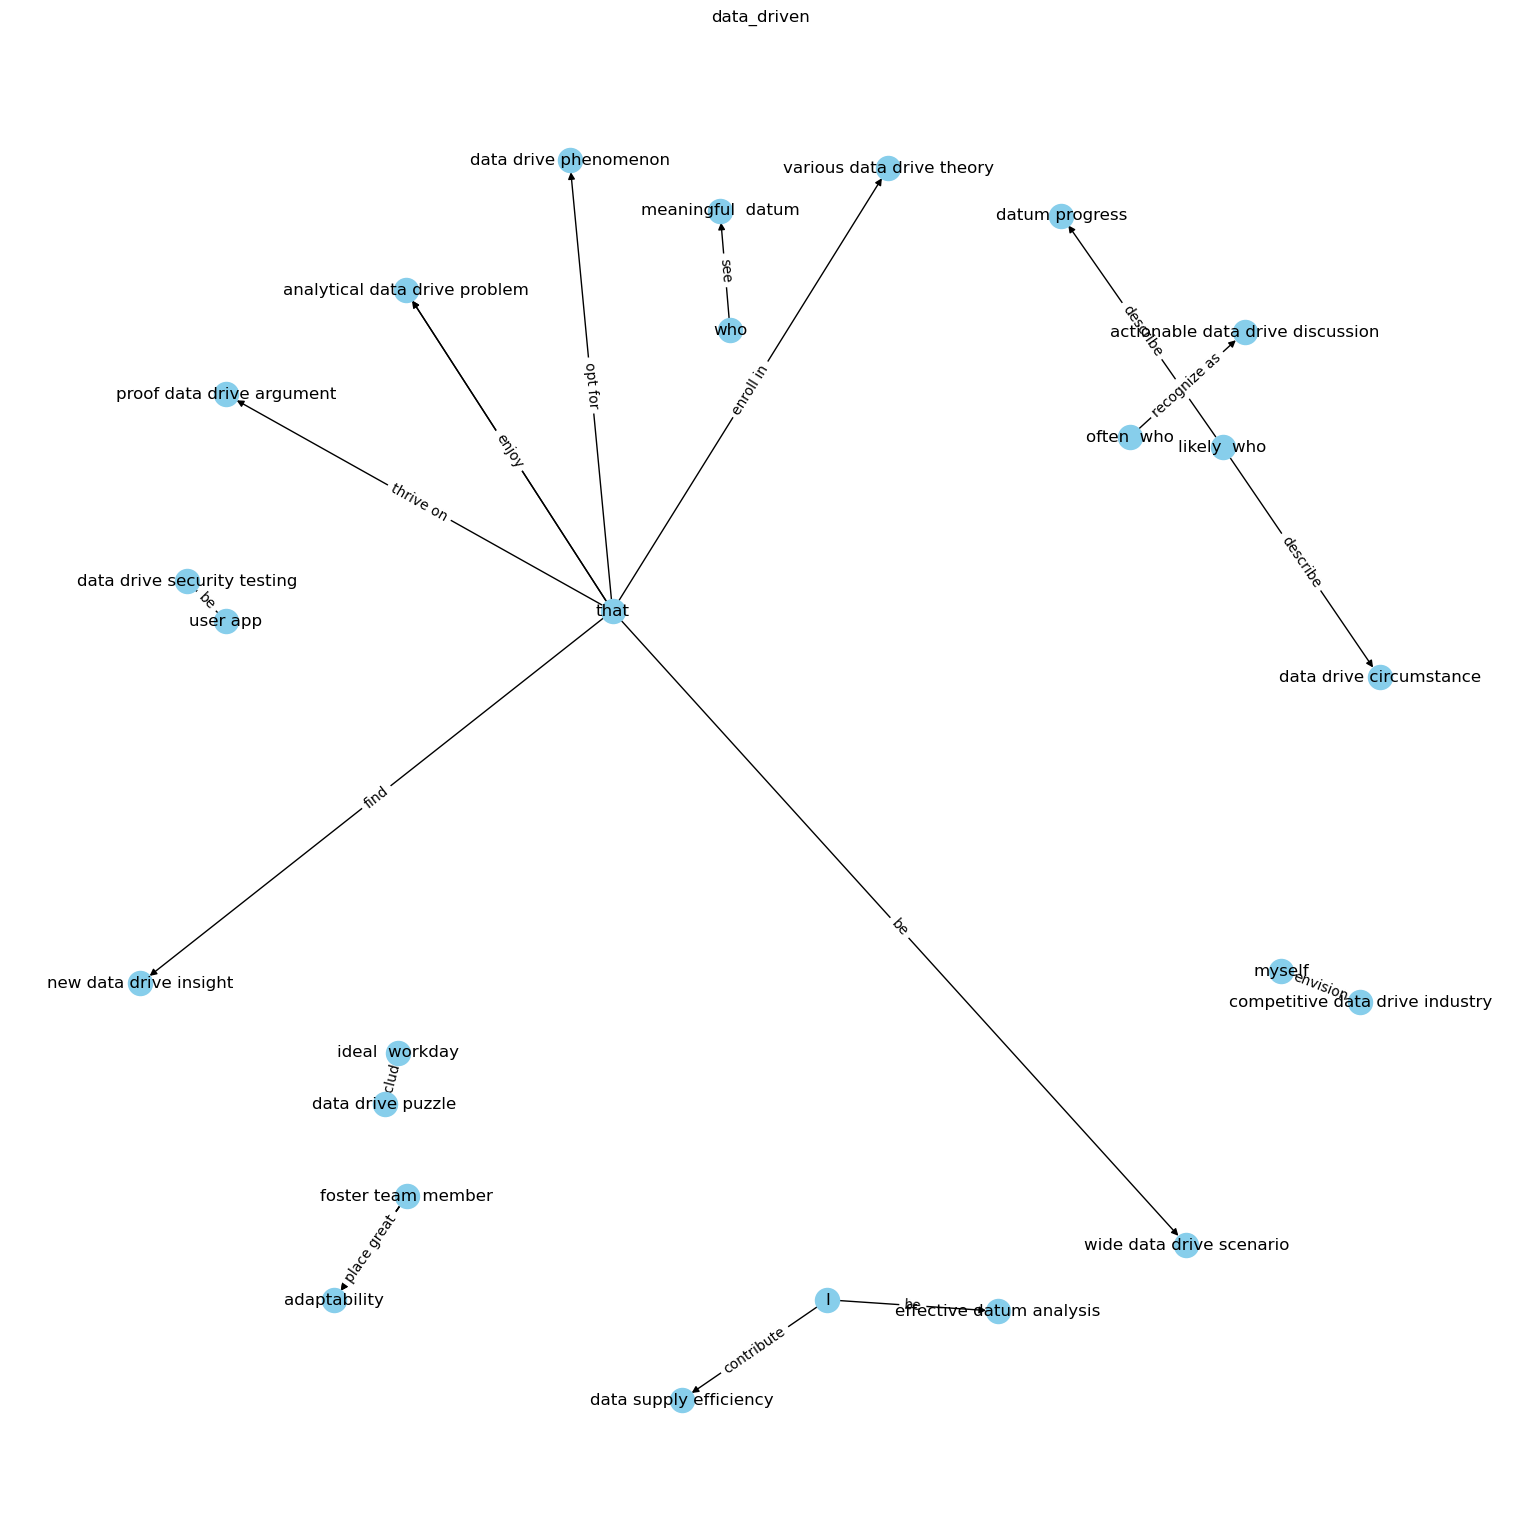

In [19]:
viz_kg(data_driven[data_driven.edge.isin(top_edge) & data_driven.source.isin(top_source)])
plt.title("data_driven")
plt.show()

In [20]:
infrastructure = get_kg_trait(career_persona, "infrastructure", cols="answer_processed")
infrastructure

100%|██████████| 53/53 [00:00<00:00, 95.41it/s] 


,source,target,edge
0,likely infrastructure who,complex infrastructure system,describe
1,likely who,optimize efficiency,describe
2,likely who,optimize efficiency,describe
3,often who,seamless infrastructure operation,recognize as
4,when detail it,infrastructure planning,see
5,loved one,reliable infrastructure relate advice,describe
6,who,technological infrastructure landscape,say
7,robust that,business,describe
8,practical infrastructure that,need,People
9,who,critical infrastructure system,see as


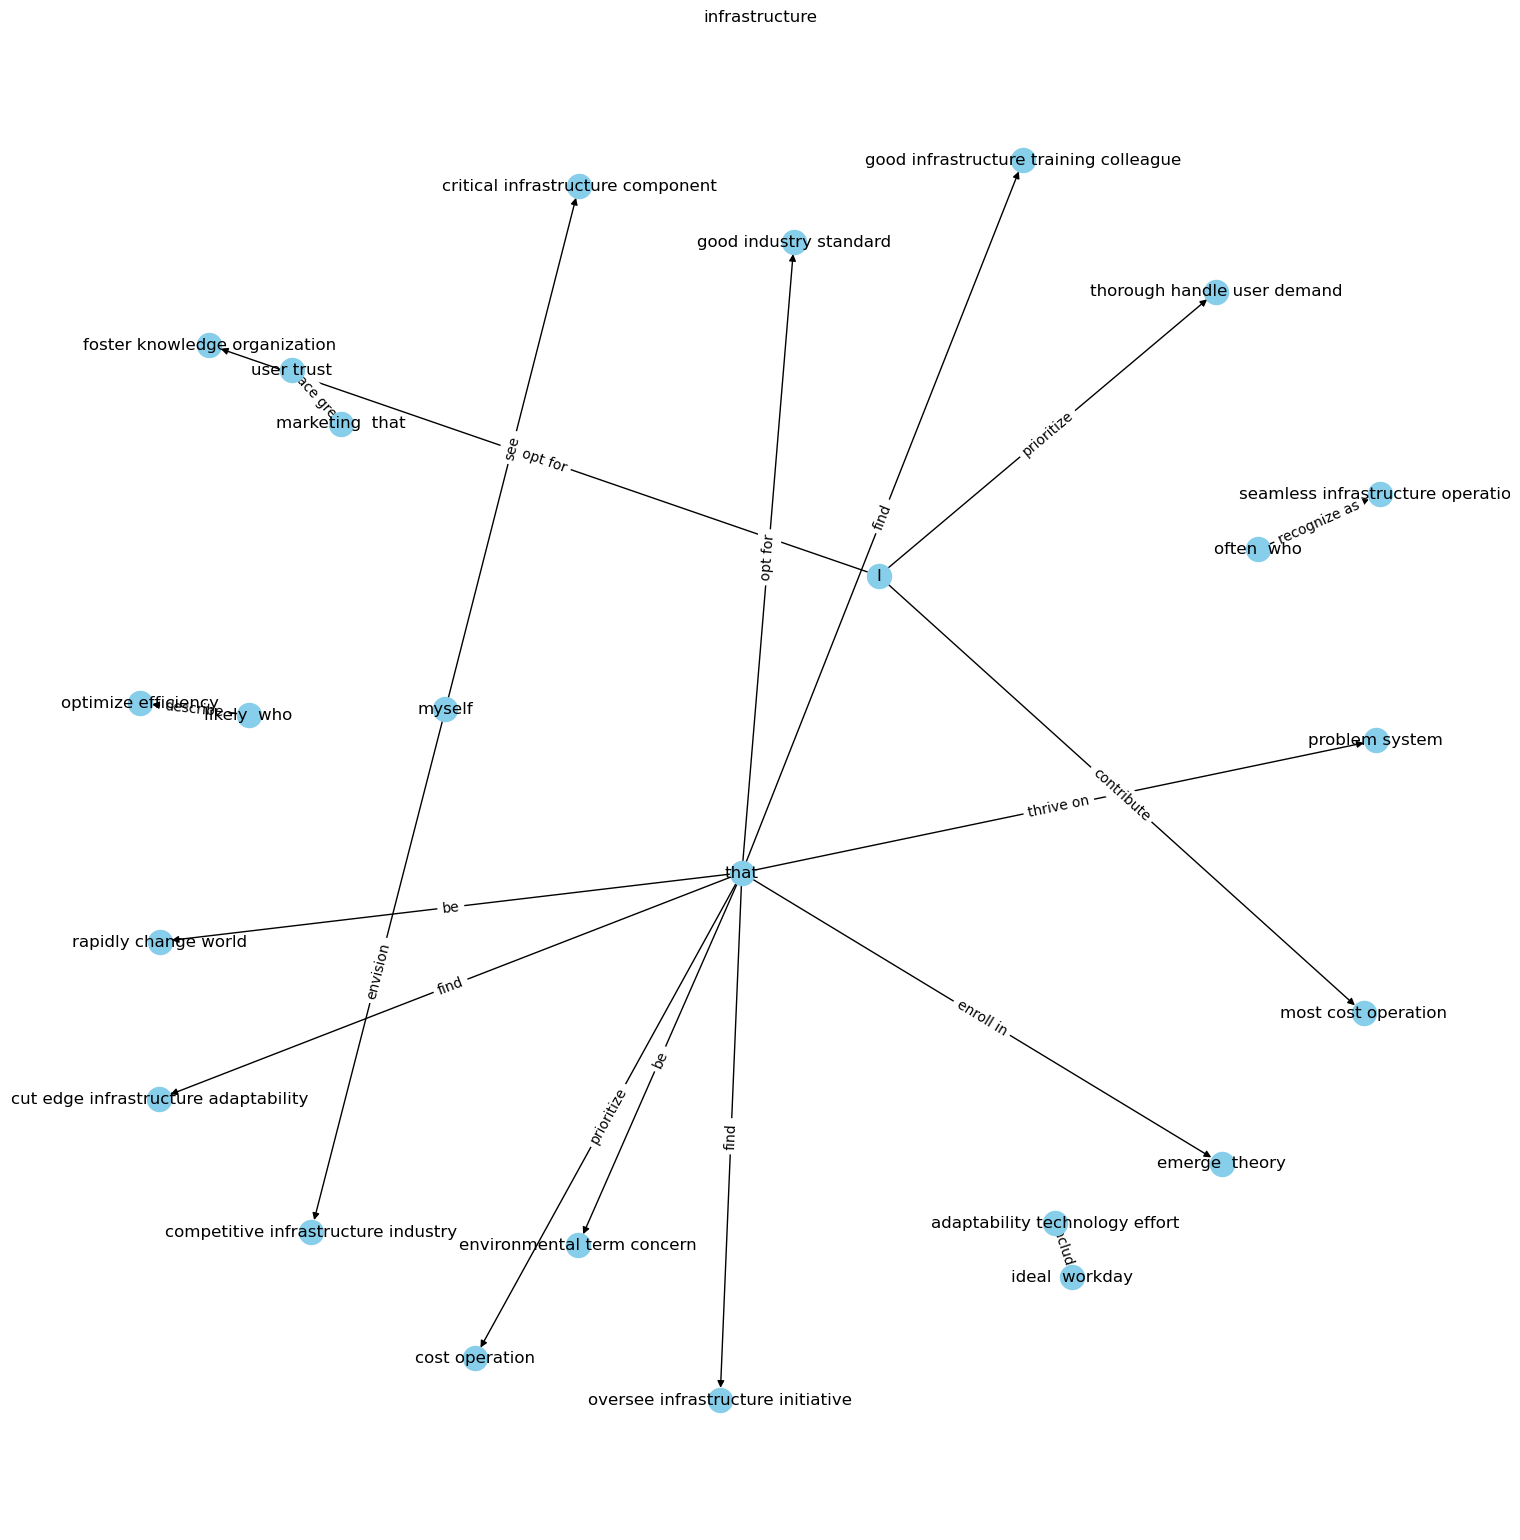

In [21]:
viz_kg(infrastructure[infrastructure.edge.isin(top_edge) & infrastructure.source.isin(top_source)])
plt.title("infrastructure")
plt.show()

In [22]:
user_focused = get_kg_trait(career_persona, "user-focused", cols="answer_processed")
user_focused

100%|██████████| 53/53 [00:00<00:00, 116.51it/s]


,source,target,edge
0,likely who,always other,describe
1,often who,well need,see as
2,other,value,describe
3,someone who,go support,label
4,likely I,always comfort,say
5,loved one,eager support,describe
6,meaningful other,meaningful relationship,regard as
7,positive I,positive those,describe
8,human need,I,choose
9,create that,need,be


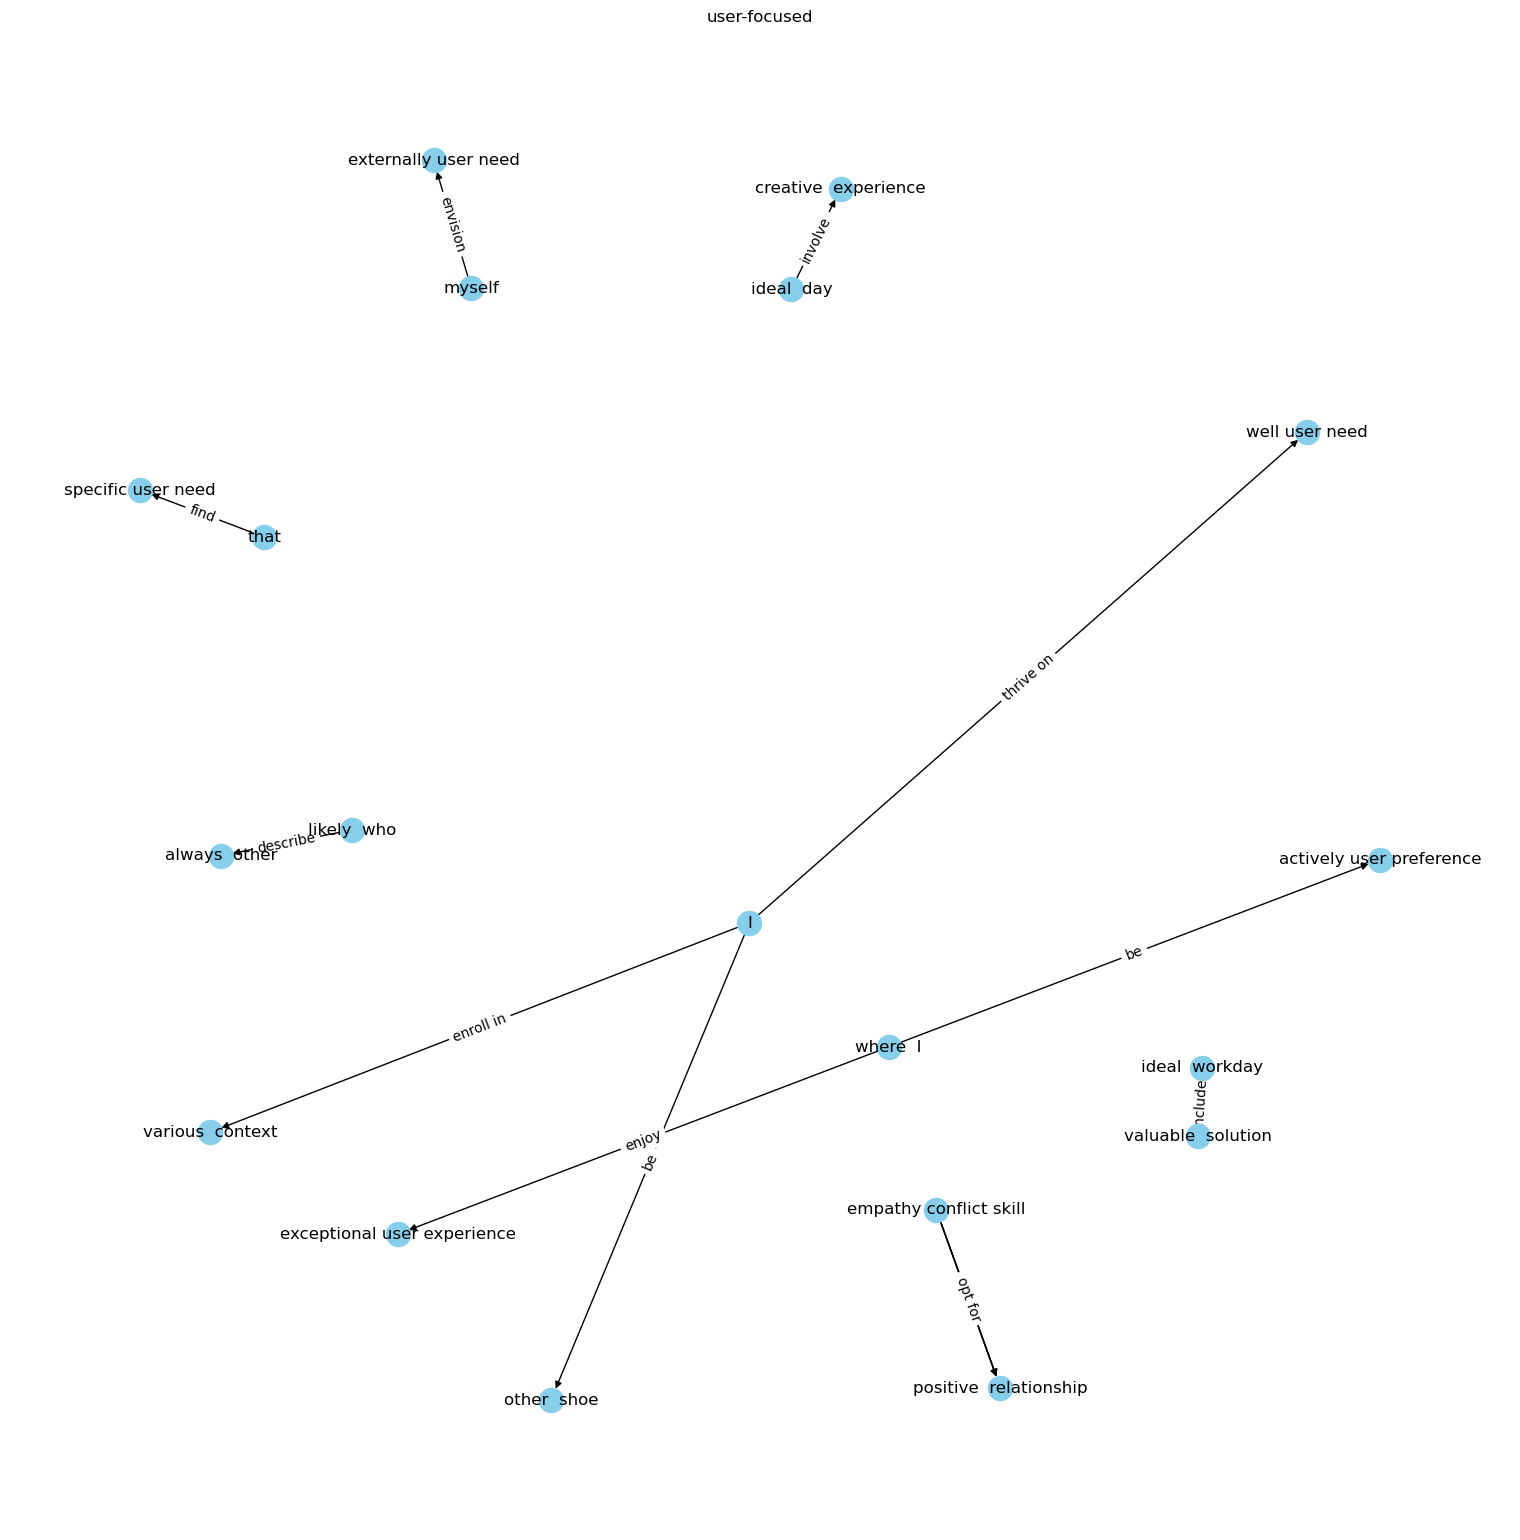

In [23]:
viz_kg(user_focused[user_focused.edge.isin(top_edge) & user_focused.source.isin(top_source)])
plt.title("user-focused")
plt.show()

In [24]:
empathetic = get_kg_trait(career_persona, "empathetic", cols="answer_processed")
empathetic

100%|██████████| 51/51 [00:00<00:00, 100.73it/s]


,source,target,edge
0,empathetic who,other well being,describe
1,likely who,other,describe
2,compassionate who,other,recognize as
3,who,there listening ear,see
4,hearted who,genuinely they,describe
5,who,emotional level,say
6,likely who,challenging situation,describe
7,I,difficult time,People
8,I,human emotion,choose
9,other,relationship,be


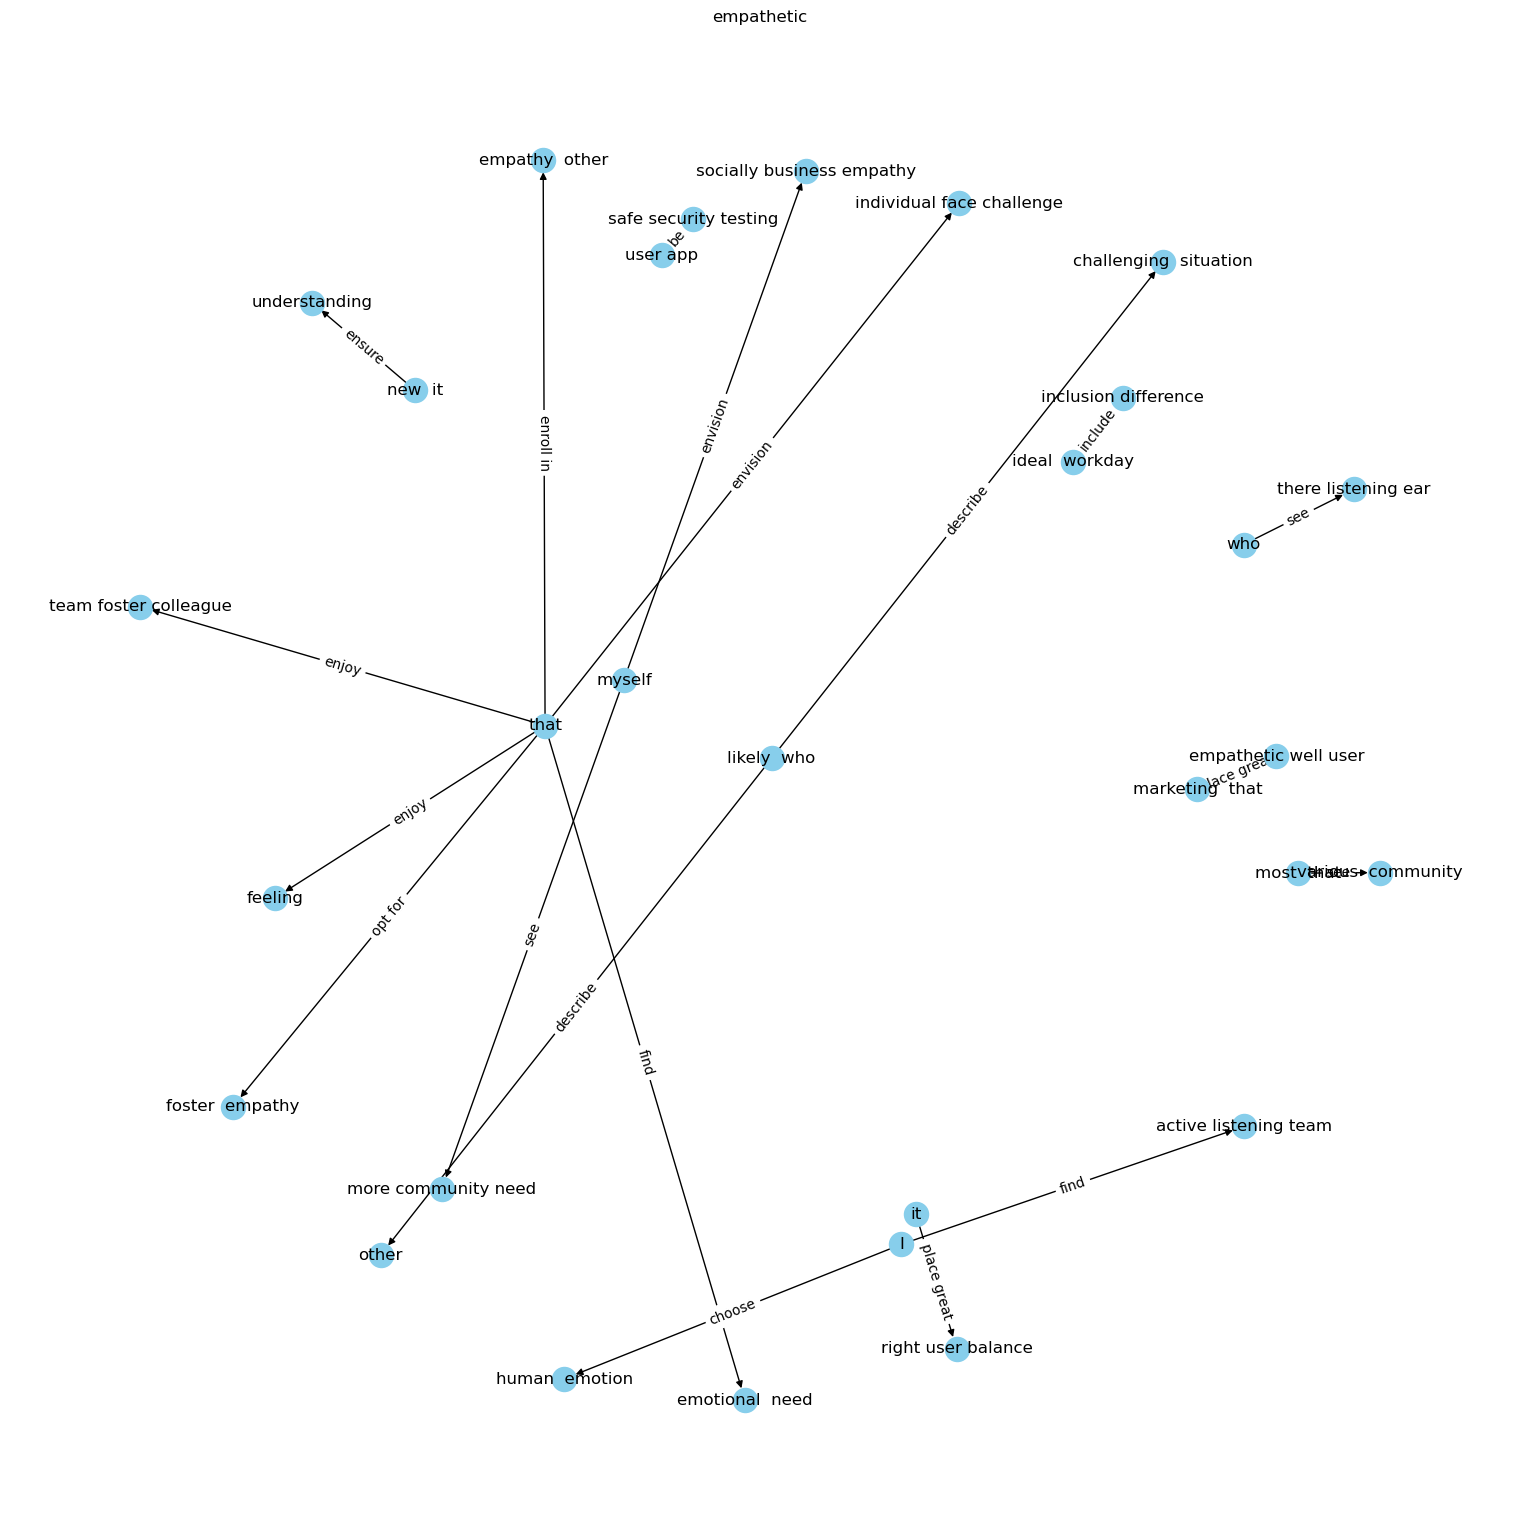

In [25]:
viz_kg(empathetic[empathetic.edge.isin(top_edge) & empathetic.source.isin(top_source)])
plt.title("empathetic")
plt.show()